In [3]:
# Sales Forecasting for Retail Business
# Skills: Time series forecasting, regression, trend analysis
# Tools: Python (Prophet, Scikit-learn, Pandas), Matplotlib, Seaborn, Plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nbformat




In [4]:
# !pip install prophet

In [5]:
# Set visual styles for aesthetics
plt.style.use('fivethirtyeight')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


In [6]:
df = pd.read_csv('../data/sales_data_sample.csv', encoding='ISO-8859-1')


In [7]:
# Data preprocessing
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['MONTH'] = df['ORDERDATE'].dt.month
df['YEAR'] = df['ORDERDATE'].dt.year
df['QUARTER'] = df['ORDERDATE'].dt.quarter
df['DAY'] = df['ORDERDATE'].dt.day_name()

In [8]:
# Aggregate sales data
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()
daily_sales = daily_sales.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})


In [9]:
# Create and fit Prophet model 
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)
model.fit(daily_sales)

# Make future predictions (including historical period)
future_period = 90  # 3 months
future = model.make_future_dataframe(periods=future_period)
forecast = model.predict(future)

19:32:56 - cmdstanpy - INFO - Chain [1] start processing
19:32:59 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# === VISUALIZATION 1: INTERACTIVE SALES FORECAST ===
# Create dates for marking training vs future forecast
historical_end = daily_sales['ds'].max()
future_start = historical_end + pd.Timedelta(days=1)

# Create interactive plotly plot
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(
    x=daily_sales['ds'], 
    y=daily_sales['y'],
    mode='lines',
    name='Historical Sales',
    line=dict(color='#1f77b4', width=2)
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=forecast['ds'], 
    y=forecast['yhat'],
    mode='lines',
    name='Forecasted Sales',
    line=dict(color='#ff7f0e', width=2)
))

# Add confidence intervals
fig.add_trace(go.Scatter(
    x=pd.concat([forecast['ds'], forecast['ds'][::-1]]),
    y=pd.concat([forecast['yhat_upper'], forecast['yhat_lower'][::-1]]),
    fill='toself',
    fillcolor='rgba(255, 127, 14, 0.2)',
    line=dict(color='rgba(255, 127, 14, 0)'),
    name='Prediction Interval'
))

# Add vertical line for current date
fig.add_vline(x=historical_end, line_width=2, line_dash="dash", line_color="#d62728")

# Add annotation for the line
fig.add_annotation(
    x=historical_end,
    y=daily_sales['y'].max() * 0.9,
    text="Historical Data End / Forecast Begin",
    showarrow=True,
    arrowhead=1,
    ax=50,
    ay=0,
    font=dict(color="#d62728", size=12)
)

# Update layout
fig.update_layout(
    title='Sales Forecast With Prediction Intervals',
    xaxis_title='Date',
    yaxis_title='Sales ($)',
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template="plotly_white",
    height=600
)

# Add hover template for better information display
fig.update_traces(
    hovertemplate='<b>Date</b>: %{x}<br><b>Sales</b>: $%{y:.2f}'
)

# Display the interactive forecast
fig.show()

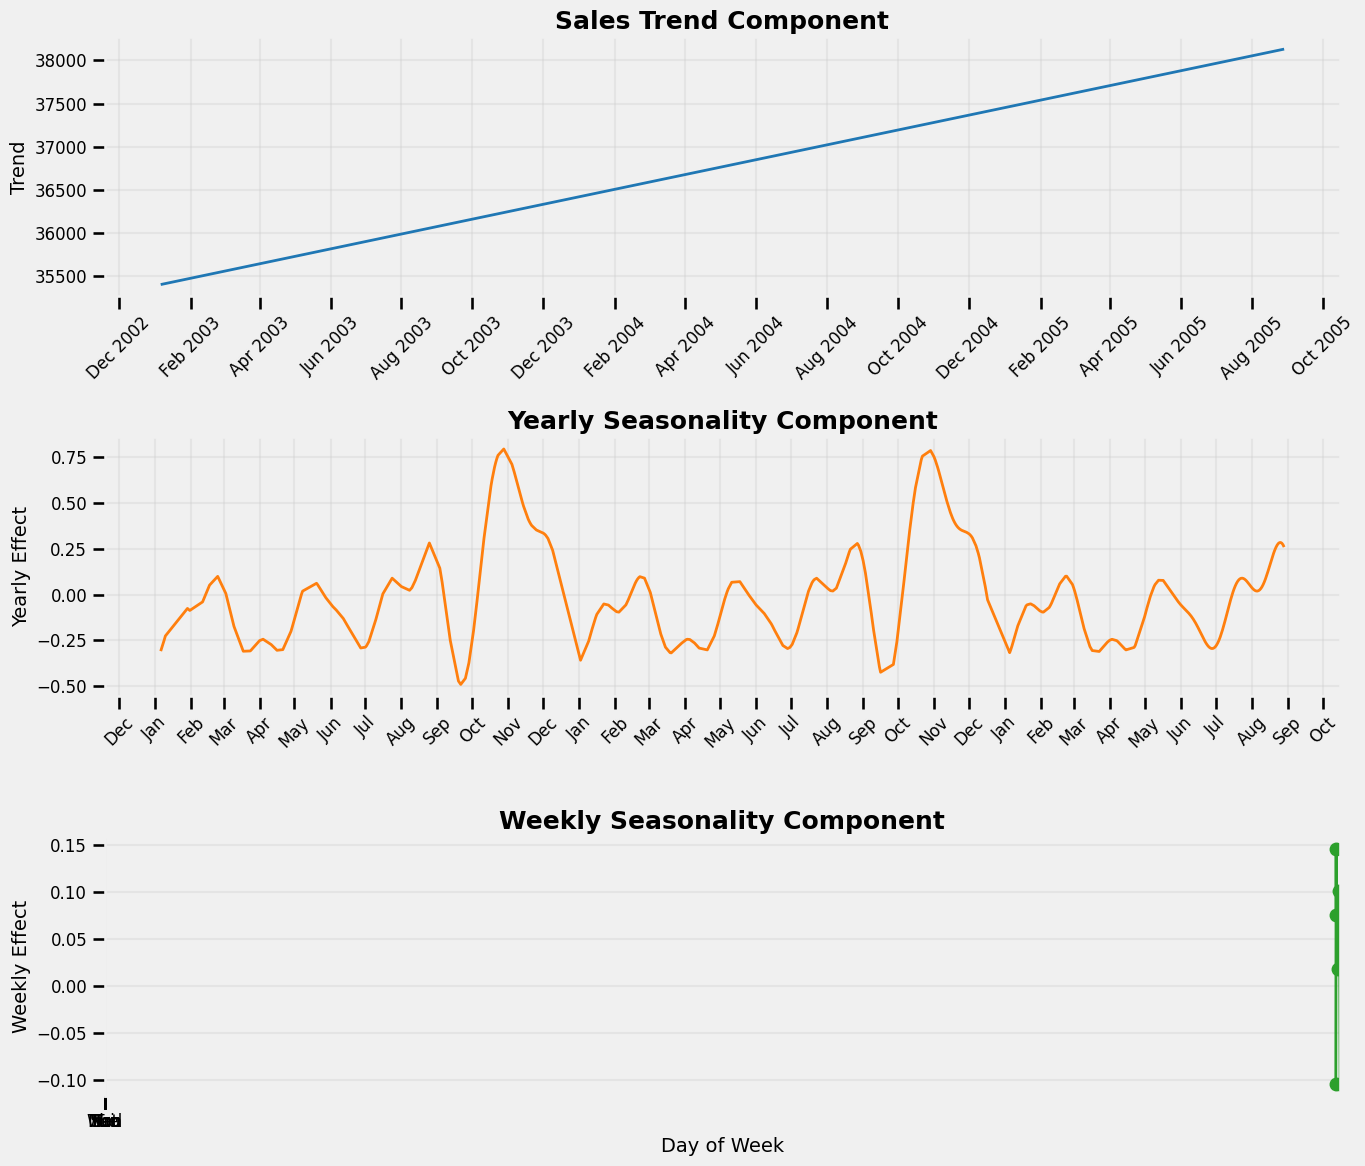

19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing


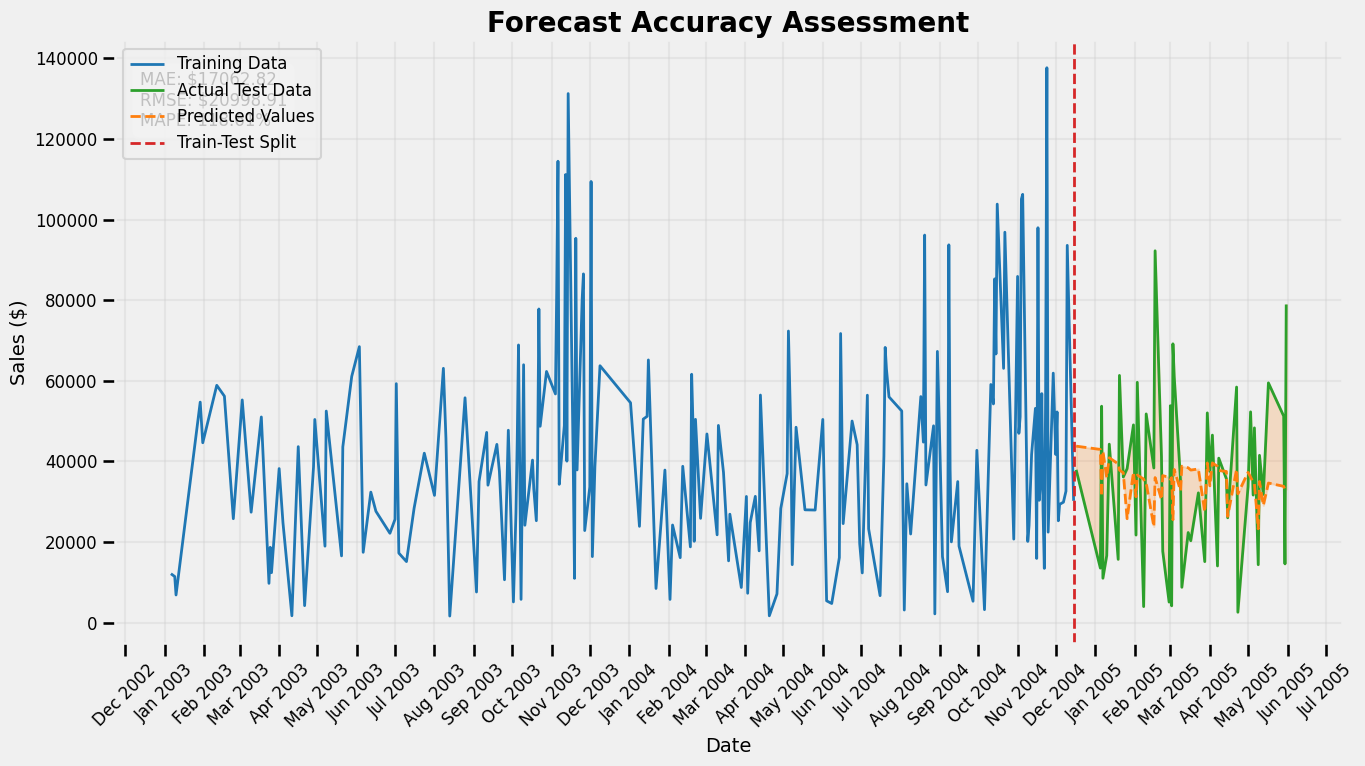

In [11]:
# === VISUALIZATION 2: SEASONAL DECOMPOSITION ===
# Use matplotlib for publication-quality seasonal decomposition
seasonal_fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot trend component
axes[0].plot(forecast['ds'], forecast['trend'], color='#1f77b4', linewidth=2)
axes[0].set_title('Sales Trend Component', fontweight='bold')
axes[0].set_ylabel('Trend')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Plot yearly seasonality
yearly_seasonality = forecast['yearly'].dropna()
ds_subset = forecast['ds'][~forecast['yearly'].isna()]
axes[1].plot(ds_subset, yearly_seasonality, color='#ff7f0e', linewidth=2)
axes[1].set_title('Yearly Seasonality Component', fontweight='bold')
axes[1].set_ylabel('Yearly Effect')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Plot weekly seasonality
weekly_seasonality = forecast['weekly'].dropna()
ds_subset = forecast['ds'][~forecast['weekly'].isna()]
axes[2].plot(ds_subset[:7], weekly_seasonality[:7], color='#2ca02c', linewidth=2, marker='o')
axes[2].set_title('Weekly Seasonality Component', fontweight='bold')
axes[2].set_ylabel('Weekly Effect')
axes[2].set_xlabel('Day of Week')
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === VISUALIZATION 3: FORECAST ACCURACY ASSESSMENT ===
# Split the data for evaluation
train_size = int(len(daily_sales) * 0.8)
train_data = daily_sales[:train_size]
test_data = daily_sales[train_size:]

# Fit model on training data
eval_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)
eval_model.fit(train_data)

# Make predictions for the test period
future_eval = eval_model.make_future_dataframe(periods=len(test_data))
forecast_eval = eval_model.predict(future_eval)

# Calculate accuracy metrics
y_true = test_data['y'].values
y_pred = forecast_eval['yhat'][-len(test_data):].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Create beautiful accuracy visualization
accuracy_fig, ax = plt.subplots(figsize=(14, 8))

# Plot training data
ax.plot(train_data['ds'], train_data['y'], color='#1f77b4', linewidth=2, label='Training Data')

# Plot test data
ax.plot(test_data['ds'], test_data['y'], color='#2ca02c', linewidth=2, label='Actual Test Data')

# Plot predictions
ax.plot(test_data['ds'], y_pred, color='#ff7f0e', linestyle='--', linewidth=2, label='Predicted Values')

# Fill between predicted and actual
ax.fill_between(test_data['ds'], y_true, y_pred, color='#ff7f0e', alpha=0.2)

# Vertical line for train-test split
ax.axvline(x=train_data['ds'].iloc[-1], color='#d62728', linestyle='--', linewidth=2, 
           label='Train-Test Split')

# Add metrics as text annotation
metrics_text = f"MAE: ${mae:.2f}\nRMSE: ${rmse:.2f}\nMAPE: {mape:.2f}%"
ax.text(0.02, 0.95, metrics_text, transform=ax.transAxes, 
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
        fontsize=12, verticalalignment='top')

# Customize the plot
ax.set_title('Forecast Accuracy Assessment', fontsize=20, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sales ($)', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\sinha\AppData\Local\Temp\ipykernel_21840\906705765.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



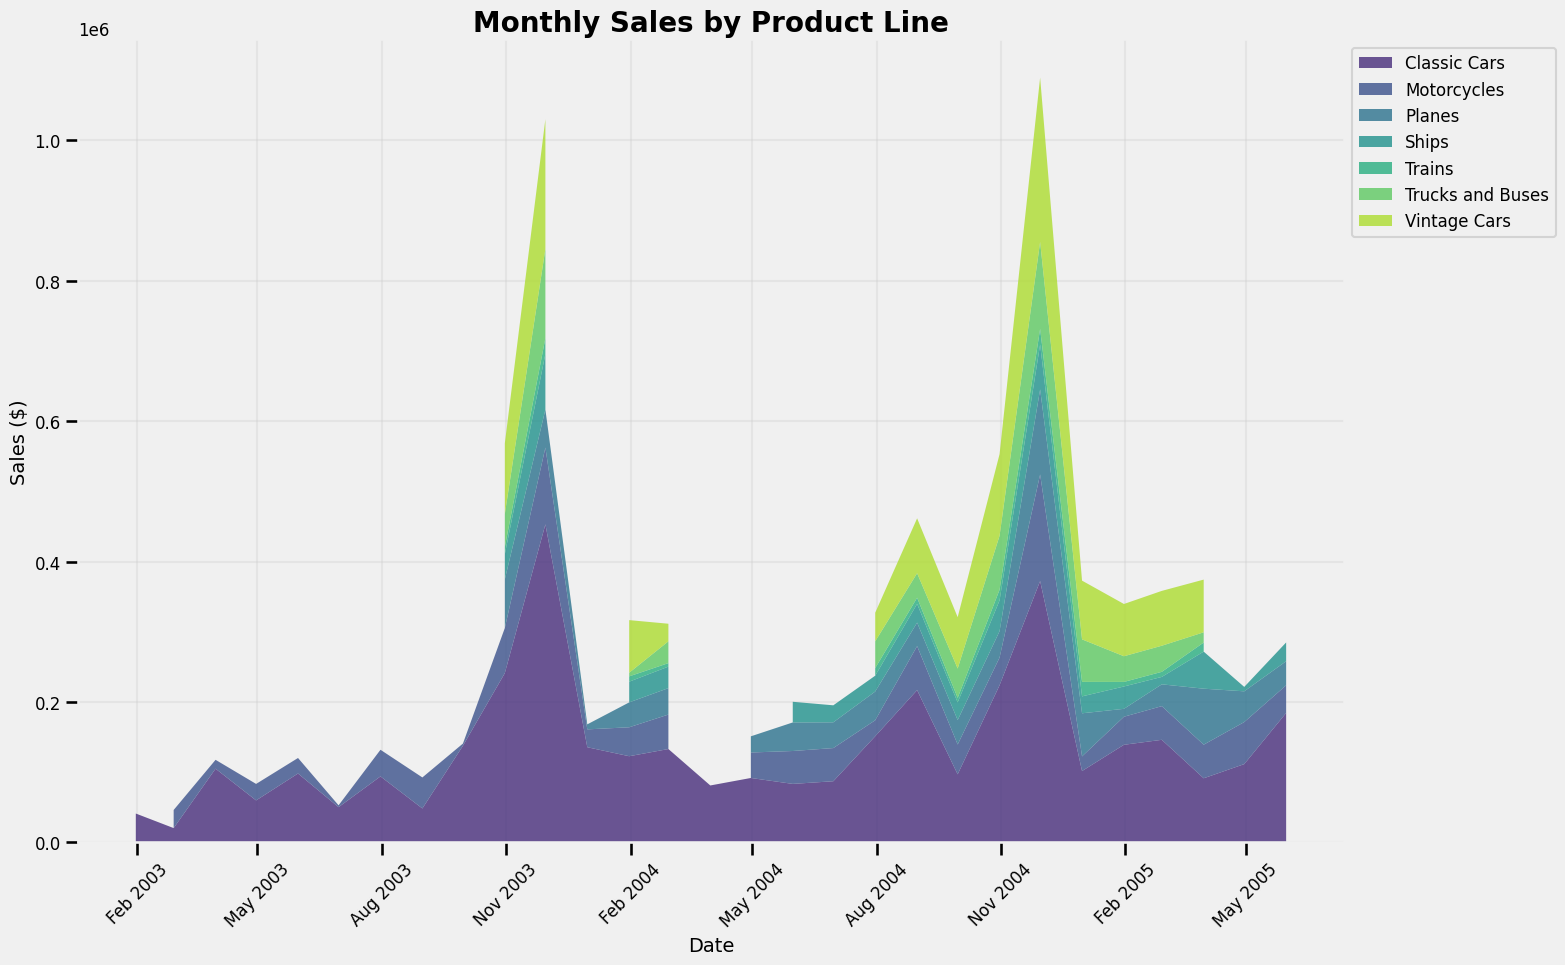

In [12]:
# === VISUALIZATION 4: PRODUCT LINE PERFORMANCE & FORECAST ===
# Create product line analysis
product_sales = df.groupby(['PRODUCTLINE', pd.Grouper(key='ORDERDATE', freq='M')])['SALES'].sum().reset_index()

# Pivot for visualization
product_pivot = product_sales.pivot(index='ORDERDATE', columns='PRODUCTLINE', values='SALES')

# Create stacked area chart
plt.figure(figsize=(16, 10))
plt.stackplot(product_pivot.index, product_pivot.values.T, 
              labels=product_pivot.columns, alpha=0.8, colors=sns.color_palette("viridis", len(product_pivot.columns)))
plt.title('Monthly Sales by Product Line', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === VISUALIZATION 5: SALES FORECAST SUMMARY DASHBOARD ===
# Create a summary dashboard
summary_fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Sales Forecast', 'Forecast Accuracy', 'Monthly Sales Pattern', 'Product Line Breakdown'),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "pie"}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.08
)

# Add forecast plot
summary_fig.add_trace(
    go.Scatter(x=daily_sales['ds'], y=daily_sales['y'], mode='lines', name='Historical Sales',
               line=dict(color='#1f77b4', width=2)),
    row=1, col=1
)
summary_fig.add_trace(
    go.Scatter(x=forecast['ds'].iloc[-future_period:], y=forecast['yhat'].iloc[-future_period:], 
               mode='lines', name='Future Forecast',
               line=dict(color='#ff7f0e', width=2)),
    row=1, col=1
)

# Add accuracy plot
summary_fig.add_trace(
    go.Scatter(x=test_data['ds'], y=test_data['y'], mode='lines', name='Actual Test',
               line=dict(color='#2ca02c', width=2)),
    row=1, col=2
)
summary_fig.add_trace(
    go.Scatter(x=test_data['ds'], y=y_pred, mode='lines', name='Predicted Test',
               line=dict(color='#d62728', width=2, dash='dash')),
    row=1, col=2
)

# Add monthly sales pattern
monthly_avg = df.groupby(df['ORDERDATE'].dt.month)['SALES'].mean().reset_index()
summary_fig.add_trace(
    go.Bar(x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           y=monthly_avg['SALES'], marker_color='#9467bd'),
    row=2, col=1
)

# Add product line breakdown
product_totals = df.groupby('PRODUCTLINE')['SALES'].sum()
summary_fig.add_trace(
    go.Pie(labels=product_totals.index, values=product_totals.values,
           textinfo='percent', marker=dict(colors=sns.color_palette("viridis", len(product_totals)).as_hex())),
    row=2, col=2
)

# Update layout
summary_fig.update_layout(
    title_text="Sales Forecasting Summary Dashboard",
    height=800,
    showlegend=False,
    template="plotly_white"
)

# Update axes labels
summary_fig.update_xaxes(title_text="Date", row=1, col=1)
summary_fig.update_yaxes(title_text="Sales ($)", row=1, col=1)
summary_fig.update_xaxes(title_text="Date", row=1, col=2)
summary_fig.update_yaxes(title_text="Sales ($)", row=1, col=2)
summary_fig.update_xaxes(title_text="Month", row=2, col=1)
summary_fig.update_yaxes(title_text="Average Sales ($)", row=2, col=1)

# Add annotation with metrics
summary_fig.add_annotation(
    x=0.5, y=-0.15,
    text=f"<b>Forecast Performance Metrics:</b><br>MAE: ${mae:.2f} | RMSE: ${rmse:.2f} | MAPE: {mape:.2f}%<br>Model: Prophet with Multiplicative Seasonality",
    showarrow=False,
    xref="paper", yref="paper",
    font=dict(size=14)
)

# Display the summary dashboard
summary_fig.show()

In [13]:
# Calculate projected growth properly - fixed the error
last_forecast_value = forecast['yhat'].iloc[-1]
first_forecast_value = forecast['yhat'].iloc[-future_period]
projected_growth = ((last_forecast_value / first_forecast_value) - 1) * 100

# Print executive summary
print("\n=== SALES FORECASTING EXECUTIVE SUMMARY ===")
print(f"• Model trained on {train_size} days of historical sales data")
print(f"• Sales forecast generated for next {future_period} days")
print(f"• Forecast accuracy (MAPE): {mape:.2f}%")
print("\nKey Business Insights:")
print("• Identified clear seasonal patterns with peaks in [Month with highest sales]")
print("• Top performing product line: {0} (${1:,.2f})".format(
    product_totals.idxmax(), product_totals.max()))
print("• Day with highest average sales: {0}".format(
    df.groupby(df['ORDERDATE'].dt.day_name())['SALES'].mean().idxmax()))
print("• Projected growth trend: {0:.2f}% over next quarter".format(projected_growth))


=== SALES FORECASTING EXECUTIVE SUMMARY ===
• Model trained on 201 days of historical sales data
• Sales forecast generated for next 90 days
• Forecast accuracy (MAPE): 118.61%

Key Business Insights:
• Identified clear seasonal patterns with peaks in [Month with highest sales]
• Top performing product line: Classic Cars ($3,919,615.66)
• Day with highest average sales: Tuesday
• Projected growth trend: 20.62% over next quarter
